In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import qqplot
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.diagnostic import het_breuschpagan
import folium
import geopandas as gpd
import json
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("merged_lsoa_crime_data.csv")
df.head()

,LSOA code (2011),LSOA name (2011),Local Authority District code (2019),Local Authority District name (2019),Index of Multiple Deprivation (IMD) Score,Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived),Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs),Income Score (rate),Income Rank (where 1 is most deprived),Income Decile (where 1 is most deprived 10% of LSOAs),...,Geographical Barriers Sub-domain Decile (where 1 is most deprived 10% of LSOAs),Wider Barriers Sub-domain Score,Wider Barriers Sub-domain Rank (where 1 is most deprived),Wider Barriers Sub-domain Decile (where 1 is most deprived 10% of LSOAs),Indoors Sub-domain Score,Indoors Sub-domain Rank (where 1 is most deprived),Indoors Sub-domain Decile (where 1 is most deprived 10% of LSOAs),Outdoors Sub-domain Score,Outdoors Sub-domain Rank (where 1 is most deprived),Outdoors Sub-domain Decile (where 1 is most deprived 10% of LSOAs)
0,E01000001,City of London 001A,E09000001,City of London,6.208,29199,9,0.007,32831,10,...,7,3.587,3216,1,0.006,16364,5,1.503,1615,1
1,E01000002,City of London 001B,E09000001,City of London,5.143,30379,10,0.034,29901,10,...,10,3.231,3894,2,-0.410,22676,7,1.196,2969,1
2,E01000003,City of London 001C,E09000001,City of London,19.402,14915,5,0.086,18510,6,...,9,5.173,818,1,-0.054,17318,6,2.207,162,1
3,E01000005,City of London 001E,E09000001,City of London,28.652,8678,3,0.211,6029,2,...,10,5.361,672,1,-0.604,25218,8,1.769,849,1
4,E01032739,City of London 001F,E09000001,City of London,13.584,20391,7,0.014,32638,10,...,3,4.153,2173,1,0.674,7046,3,1.850,652,1


In [2]:

target = 'Crime Score'
features = [
    'Income Score (rate)', 'Employment Score (rate)', 
    'Education, Skills and Training Score', 'Health Deprivation and Disability Score',
    'Barriers to Housing and Services Score', 'Living Environment Score',
    'Children and Young People Sub-domain Score', 'Adult Skills Sub-domain Score',
    'Wider Barriers Sub-domain Score', 'Indoors Sub-domain Score', 'Outdoors Sub-domain Score'
]

data = df[[target] + features].dropna()
X = data[features].copy()
y = data[target]

# Standardize features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Add interaction term
X_scaled['Skills_Health_Interaction'] = X_scaled['Adult Skills Sub-domain Score'] * X_scaled['Health Deprivation and Disability Score']
X_scaled_const = sm.add_constant(X_scaled)


In [3]:
model = sm.OLS(y, X_scaled_const).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Crime Score   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     289.6
Date:                Wed, 14 May 2025   Prob (F-statistic):               0.00
Time:                        21:34:14   Log-Likelihood:                -2840.5
No. Observations:                4835   AIC:                             5707.
Df Residuals:                    4822   BIC:                             5791.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                          0.2651      0.008     34.807      0.000       0.250       0.280
Income Score (rate)                            0.0347      0.025      1.403      0.161      -0.014       0.083
Employment Score (rate)                        0.0523      0.022      2.407      0.016       0.010       0.095
Education, Skills and Training Score          -0.0067      0.025     -0.264      0.792      -0.056       0.043
Health Deprivation and Disability Score        0.0663      0.012      5.365      0.000       0.042       0.090
Barriers to Housing and Services Score        -0.0005      0.013     -0.035      0.972      -0.027       0.026
Living Environment Score                      -0.1665      0.030     -5.534      0.000      -0.226      -0.108
Children and Young People Sub-domain Score     0.0362      0.014      2.509      0.012       0.008       0.064
Adult Skills Sub-domain Score                  0.0984      0.020      5.017      0.000       0.060       0.137
Wider Barriers Sub-domain Score                0.0094      0.017      0.562      0.574      -0.023       0.042
Indoors Sub-domain Score                       0.1485      0.021      7.239      0.000       0.108       0.189
Outdoors Sub-domain Score                      0.3418      0.021     16.382      0.000       0.301       0.383
Skills_Health_Interaction                     -0.0132      0.008     -1.565      0.118      -0.030       0.003
==============================================================================
Omnibus:                       87.092   Durbin-Watson:                   1.532
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              152.325
Skew:                          -0.135   Prob(JB):                     8.38e-34
Kurtosis:                       3.827   Cond. No.                         15.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

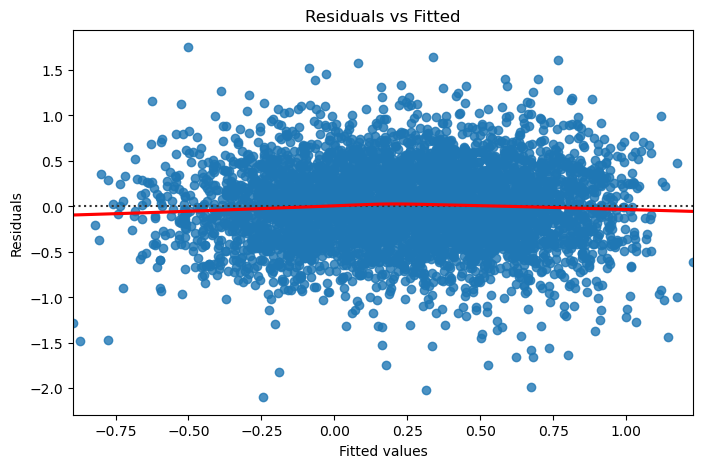

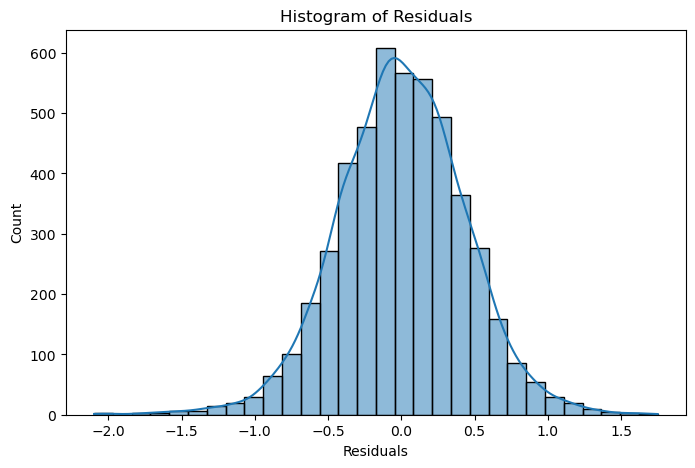

<Figure size 600x600 with 0 Axes>

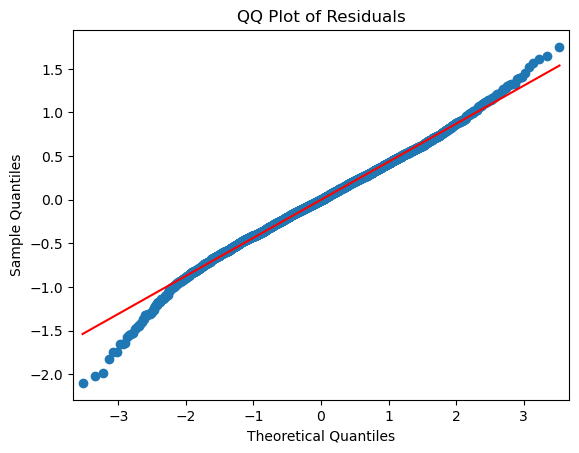

In [4]:

plt.figure(figsize=(8,5))
sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True, line_kws={'color': 'red'})
plt.title("Residuals vs Fitted")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(model.resid, kde=True, bins=30)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.show()

plt.figure(figsize=(6,6))
qqplot(model.resid, line='s')
plt.title("QQ Plot of Residuals")
plt.show()


In [5]:

bp_test = het_breuschpagan(model.resid, model.model.exog)
print("Breusch-Pagan test p-value:", bp_test[1])

vif_data = pd.DataFrame()
vif_data["Feature"] = X_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]
vif_data


Breusch-Pagan test p-value: 1.4669772400500144e-22


,Feature,VIF
0,Income Score (rate),15.541082
1,Employment Score (rate),11.963111
2,"Education, Skills and Training Score",14.460164
3,Health Deprivation and Disability Score,3.629295
4,Barriers to Housing and Services Score,4.589610
5,Living Environment Score,23.031463
6,Children and Young People Sub-domain Score,4.861040
7,Adult Skills Sub-domain Score,8.926668
8,Wider Barriers Sub-domain Score,7.134676
9,Indoors Sub-domain Score,10.697310


Random Forest R²: 0.4
MAE: 0.337
RMSE: 0.428


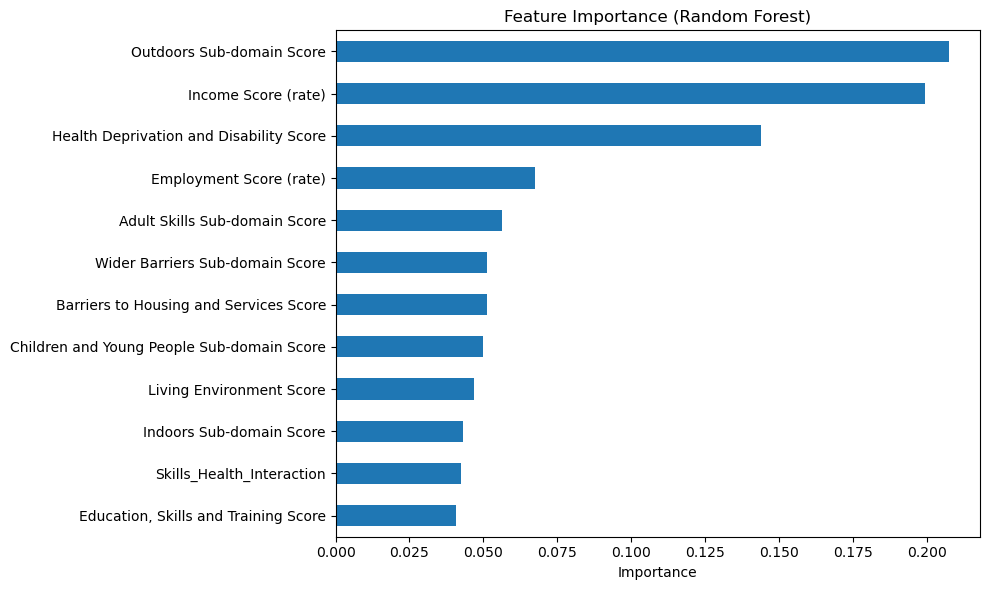

In [6]:

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Random Forest R²:", round(r2_score(y_test, y_pred), 3))
print("MAE:", round(mean_absolute_error(y_test, y_pred), 3))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred)), 3))

importances = pd.Series(rf.feature_importances_, index=X_scaled.columns)
plt.figure(figsize=(10,6))
importances.sort_values().plot(kind='barh')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


Ridge alpha: 4.9770
R² (Ridge): 0.402
Lasso alpha: 0.0010
R² (Lasso): 0.403


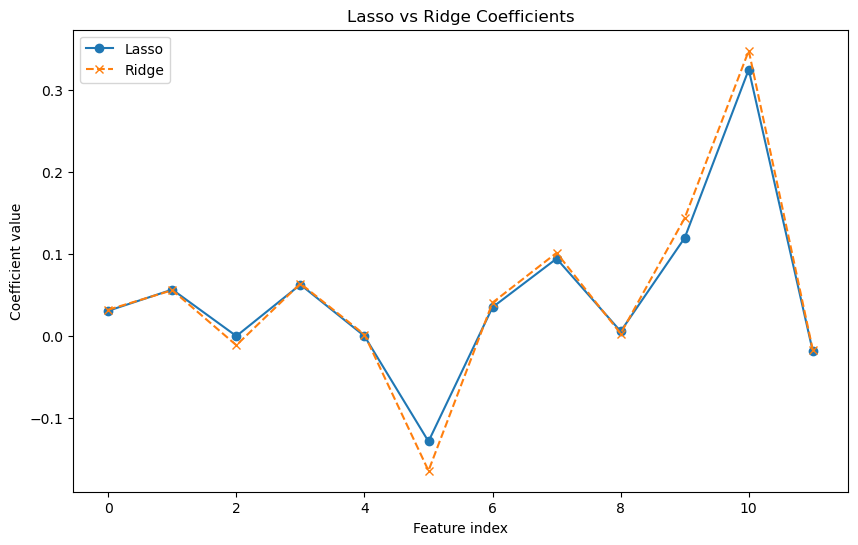

In [7]:
from sklearn.linear_model import RidgeCV, LassoCV

# Use the same scaled feature matrix from earlier
X_scaled_array = X_scaled_const.drop('const', axis=1).values  # drop constant for sklearn
y_array = y.values

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_array, y_array, test_size=0.2, random_state=42)

# Ridge regression with built-in CV
ridge = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5)
ridge.fit(X_train, y_train)
ridge_preds = ridge.predict(X_test)

print(f"Ridge alpha: {ridge.alpha_:.4f}")
print(f"R² (Ridge): {r2_score(y_test, ridge_preds):.3f}")

# Lasso regression with built-in CV
lasso = LassoCV(alphas=np.logspace(-3, 3, 100), cv=5, max_iter=10000)
lasso.fit(X_train, y_train)
lasso_preds = lasso.predict(X_test)

print(f"Lasso alpha: {lasso.alpha_:.4f}")
print(f"R² (Lasso): {r2_score(y_test, lasso_preds):.3f}")

# Plot coefficients
plt.figure(figsize=(10, 6))
plt.plot(lasso.coef_, 'o-', label='Lasso')
plt.plot(ridge.coef_, 'x--', label='Ridge')
plt.title("Lasso vs Ridge Coefficients")
plt.xlabel("Feature index")
plt.ylabel("Coefficient value")
plt.legend()
plt.show()


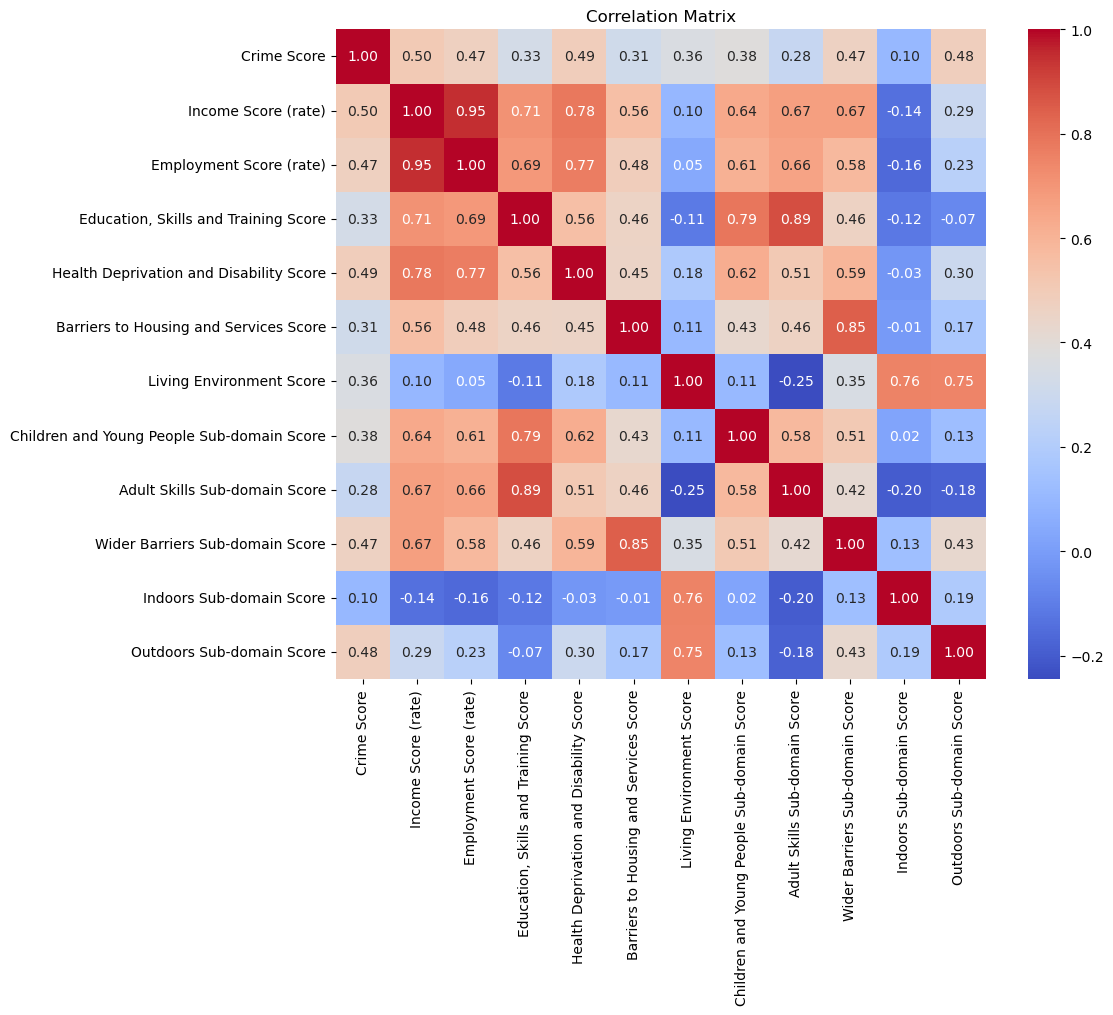

In [8]:

plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


## Regression summary
 trained multiple models:

- **OLS (Linear Regression)**: Interpretable, with R² = 0.419
- **Ridge & Lasso Regression**: Shrink coefficients to reduce overfitting (R² ≈ 0.402)
- **Random Forest**: Captures non-linearity with top R² = 0.40

## Final Equation //based on ols

\[
\hat{Y} = 0.265 + 0.0347 x_1 + 0.0523 x_2 - 0.0067 x_3 + 0.0663 x_4 - 0.0005 x_5 - 0.1665 x_6 + 0.0362 x_7 + 0.0984 x_8 + 0.0094 x_9 + 0.1485 x_{10} + 0.3418 x_{11} - 0.0132 (x_8 \cdot x_4)
\]

Where:

- \(x_1\): Income Score  
- \(x_2\): Employment Score  
- \(x_3\): Education  
- \(x_4\): Health  
- \(x_5\): Housing Barriers  
- \(x_6\): Living Environment  
- \(x_7\): Children Subdomain  
- \(x_8\): Adult Skills  
- \(x_9\): Wider Barriers  
- \(x_{10}\): Indoors  
- \(x_{11}\): Outdoors

---

## Next

To forecast **when** burglary will occur:
1. Get **historic monthly time-series data** per LSOA
2. Join with temporal indicators (season, weekday, holidays)